In [97]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 11:38:35 2023 

The MPC controller takes in the previous RTN state computed (not the measured 'x' variable)
"""

import math
import matplotlib.pyplot as plt
import numpy as np

from math import sqrt, sin, asin, cos, tan, atan2, pi
from numpy.linalg import norm, inv, pinv
from scipy.linalg import expm, sinm, cosm

from source import spacecraft
from aa273_control import *


In [98]:
##############################################################################
##############################################################################
###                                                                        ###
###              AUXILIARY FUNCTIONS FOR GPS CONSTELLATION                 ###
###                                                                        ###
##############################################################################
##############################################################################
def get_hill_frame(r, v):
    h = np.cross(r, v)  # Angular momentum vector
    r_hat = r / np.linalg.norm(r)  # Local X-axis (R)
    h_hat = h / np.linalg.norm(h)  # Local Z-axis (N)
    y_hat = np.cross(h_hat, r_hat)  # Local Y-axis (T)
    return np.array([r_hat, y_hat, h_hat])

def rtn_to_eci(target_ECI, chaser_RTN):
    r_target = target_ECI[0:3]
    v_target = target_ECI[3:6]
    r_chaser = chaser_RTN[0:3]
    v_chaser = chaser_RTN[3:6]
    matrix_rtn2eci = get_hill_frame(r_target, v_target)
    nuDot = norm(np.cross(r_target, v_target)) / (norm(r_target)**2)
    omega = np.array([0.0, 0.0, nuDot])
    rho = np.transpose(matrix_rtn2eci) @ r_chaser
    rhoDot = np.transpose(matrix_rtn2eci) @ (v_chaser + np.cross(omega, r_chaser))
    
    chaser_relative_ECI = np.zeros(6)
    chaser_relative_ECI[0:3] = rho
    chaser_relative_ECI[3:6] = rhoDot

    chaser_ECI = chaser_relative_ECI + target_ECI
    return chaser_ECI # Chaser in ECI frame

def eci_to_rtn(target_ECI, chaser_ECI):
    r_target = target_ECI[0:3]
    v_target = target_ECI[3:6]

    chaser_relative_ECI = chaser_ECI - target_ECI
    rho = chaser_relative_ECI[0:3]
    rhoDot = chaser_relative_ECI[3:6]

    nuDot = norm(np.cross(r_target, v_target)) / (norm(r_target)**2)
    omega = np.array([0.0, 0.0, nuDot])
    matrix_rtn2eci = get_hill_frame(r_target, v_target)

    r_chaser = matrix_rtn2eci @ rho
    v_chaser = matrix_rtn2eci @ rhoDot - np.cross(omega, r_chaser)

    chaser_RTN = np.zeros(6)
    chaser_RTN[0:3] = r_chaser
    chaser_RTN[3:6] = v_chaser

    return chaser_RTN # Chaser in RTN frame



In [99]:

# Function to convert ECEF (xyz) to Geodetic (lat-lon-alt) coordinates
def ecef_to_geodetic(pos):
    if len(pos) != 3:
        raise ValueError('ECEF to Geodetic: Position vector must be length 3!')
        return np.array([0,0,0])
    earthRad = 6378136.300       # Radius of Earth (WGS84)
    earthEcc = 0.081819190842622 # Earth eccentricity (WGS84)
    x, y, z, r = pos[0], pos[1], pos[2], norm(pos)
    lon = atan2(y,x)
    lat0 = asin(z/r) 
    lat = lat0 # Initial guess
    n, nMax = 0, 3 # Number of iterations
    error, tol = 1, 1E-12
    rxy = norm([x,y])
    while (error > tol) and (n < nMax):
        lat0 = lat
        N = earthRad / sqrt(1 - (earthEcc * sin(lat0))**2)
        lat = atan2(z + (N * earthEcc * earthEcc) * sin(lat0), rxy)
        error = abs(lat - lat0)
        n += 1
    alt = (rxy - cos(lat)) - N
    geodetic = np.array([lat, lon, alt])
    return geodetic

# Computes the azimuth, elevation, and range from positions 0 to 1
def compute_aer(pos0, pos1):
    lla = ecef_to_geodetic(pos0)
    lat, lon = lla[0], lla[1]
    so = sin(lon)
    co = cos(lon)
    sa = sin(lat)
    ca = cos(lat)
    rotation = np.array(
        [[-so,            co, 0.0],
         [-sa * co, -sa * so, ca ],
         [ ca * co,  ca * so, sa ]])
    enu = rotation @ (pos1 - pos0)
    azim = atan2(enu[0], enu[1]);
    elev = atan2(enu[2], norm(enu[0:2]));
    rnge = norm(enu);
    enu = np.array([azim, elev, rnge]);
    return enu


In [100]:

##############################################################################
##############################################################################
###                                                                        ###
###               SETTING UP OF THE ACTUAL FLIGHT SIMULATION               ###
###                                                                        ###
##############################################################################
##############################################################################
dt = 10
duration = 5000
timesteps = math.floor(duration / dt)

P_cost = np.eye(6)*1e2 # terminal state cost matrix
Q_cost = np.diag([1., 1, 1, 1e-3, 1e-3, 1e-3]) # state cost matrix
R_cost = 1e2*np.eye(3) # control cost matrix

N = 10 # MPC step horizon
max_iters = 500 # maximum number of iterations for SCP  
eps = 1 # tolerance for SCP


#Define Spacecrafts
sc1_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800, -100]
sc1 = spacecraft.Spacecraft( elements = sc1_elements )

target_sc_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800,  -99]
sc_target = spacecraft.Spacecraft( elements = target_sc_elements )


sc1.forces['maneuvers'] = True

# Initialize the state history
chaser_ECI_history = np.zeros((timesteps, 6))
target_ECI_history = np.zeros((timesteps, 6))

chaser_RTN_history = np.zeros((timesteps, 6))

chaser_MPC_history = np.zeros((timesteps, N-1, 6))

thrust_history = np.zeros((timesteps, 3))

u_ECI = np.zeros(3)

In [101]:
##############################################################################
##############################################################################
###                                                                        ###
###                    ACTUAL FLIGHT SIMULATION BELOW                      ###
###                                                                        ###
##############################################################################
##############################################################################


# For loop, generate ground truth `xt` and noisy measurements `y`.
for k in range(timesteps):
    print('---Iteration: ', k)
    # Propagate the true states of all spacecraft using RK4 propagator
    sc1.set_thruster_acceleration(u_ECI/sc1.mass)
    sc1.propagate_perturbed(dt, dt)
    
    sc_target.propagate_orbit(dt)
    
    # Record states
    target_eci_k = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    chaser_eci_k = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
    chaser_ECI_history[k, :] = chaser_eci_k
    target_ECI_history[k, :] = target_eci_k
    
    chaser_RTN = eci_to_rtn(target_eci_k, chaser_eci_k)
    chaser_RTN_history[k, :] = chaser_RTN

    # u_ECI = np.zeros(3)

    # Use MPC to compute the optimal control input
    # MPC begins at previous state (takes in RTN) and attempts to reach origin in RTN frame
    x_mpc, u_mpc = do_MPC(dt, sc1.n, sc1.mass, chaser_RTN, np.zeros(6), N, Q_cost, R_cost, P_cost, max_iters, eps)
    chaser_MPC_history[k, :, :] = x_mpc[2:, :]

    # Convert the MPC output to ECI
    u_ECI =  get_hill_frame(chaser_eci_k[0:3], chaser_eci_k[3:6]) @ u_mpc[1, :]
    thrust_history[k, :] = u_ECI
    # print(u_mpc[1, :])
    # print('u_ECI (N): ', u_ECI)
    # print('u_ECI accel (km/s^2): ', u_ECI/sc1.mass)

    # print('x_mpc: ', x_mpc)
    # print('u_ECI: ', u_ECI)
    


---Iteration:  0
Converged in 2 iterationss
---Iteration:  1
Converged in 2 iterationss
---Iteration:  2
Converged in 2 iterationss
---Iteration:  3
Converged in 2 iterationss
---Iteration:  4
Converged in 2 iterationss
---Iteration:  5
Converged in 2 iterationss
---Iteration:  6
Converged in 2 iterationss
---Iteration:  7
Converged in 2 iterationss
---Iteration:  8
Converged in 2 iterationss
---Iteration:  9
Converged in 2 iterationss
---Iteration:  10
Converged in 2 iterationss
---Iteration:  11
Converged in 2 iterationss
---Iteration:  12
Converged in 2 iterationss
---Iteration:  13
Converged in 2 iterationss
---Iteration:  14
Converged in 2 iterationss
---Iteration:  15
Converged in 2 iterationss
---Iteration:  16
Converged in 2 iterationss
---Iteration:  17
Converged in 2 iterationss
---Iteration:  18
Converged in 2 iterationss
---Iteration:  19
Converged in 2 iterationss
---Iteration:  20
Converged in 2 iterationss
---Iteration:  21
Converged in 2 iterationss
---Iteration:  22
Co

RuntimeError: SCP did not converge! dJ = inf

In [ ]:
print(u_mpc)

print([np.linalg.norm(u_mpc[i], np.inf) for i in range(N-1)])

[[ 9.33705543e-19  9.33705543e-19 -2.97028467e-19]
 [ 4.61390398e-06 -7.53772911e-03  1.88790615e-03]
 [ 1.95944065e-05 -7.81338944e-02  2.42332327e-02]
 [ 5.10731816e-05 -3.31636934e-02 -3.87109889e-04]
 [ 9.99607139e-05  7.01363563e-03  3.44833903e-03]
 [ 1.52811564e-04  5.40078985e-02 -4.67392367e-04]
 [ 1.81902516e-04 -2.04321727e-03 -4.53230799e-04]
 [ 1.70183638e-04 -4.49895536e-03 -3.97988640e-04]
 [ 1.21322144e-04 -5.66816610e-04 -2.85686757e-04]
 [ 4.59093191e-05 -1.52430136e-03 -1.10219833e-04]]
[9.33705542904302e-19, 0.007537729110373576, 0.07813389436702532, 0.03316369341171759, 0.007013635631856479, 0.05400789852846646, 0.002043217273621753, 0.004498955359204007, 0.0005668166100438649]


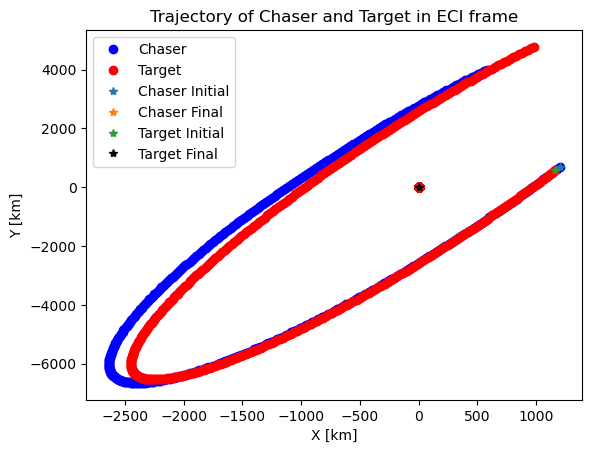

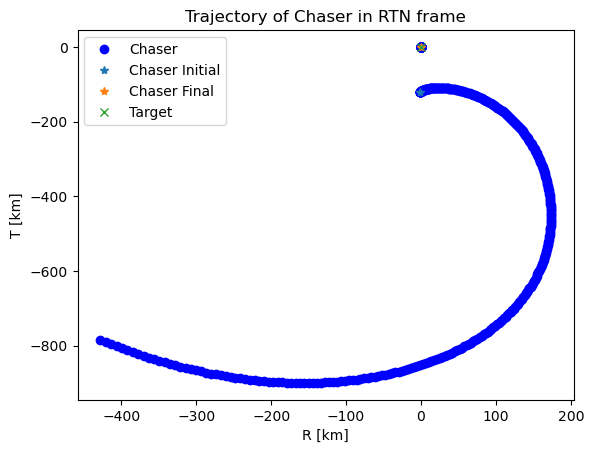

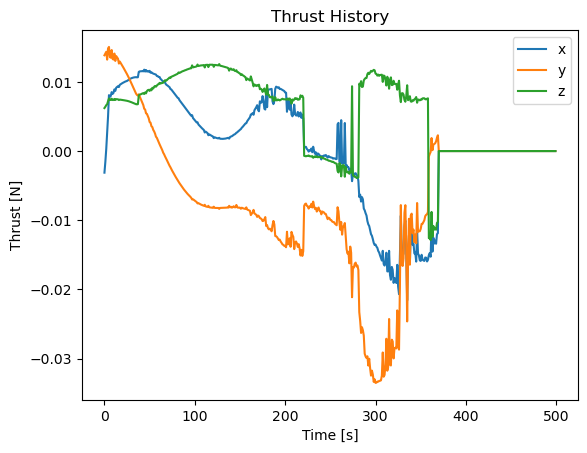

In [102]:
# ##############################################################################
# ##############################################################################
# ###                                                                        ###
# ###                               PLOTTING                                 ###
# ###                                                                        ###
# ##############################################################################
# ##############################################################################

# Plot the trajectory of the chaser and target in ECI frame
plt.figure()
plt.plot(chaser_ECI_history[1:, 0], chaser_ECI_history[1:, 1], 'bo', label='Chaser')
plt.plot(target_ECI_history[1:, 0], target_ECI_history[1:, 1], 'ro', label='Target')
plt.plot(chaser_ECI_history[1, 0], chaser_ECI_history[1, 1], '*', label='Chaser Initial')
plt.plot(chaser_ECI_history[-1, 0], chaser_ECI_history[-1, 1], '*', label='Chaser Final')
plt.plot(target_ECI_history[1, 0], target_ECI_history[1, 1], '*', label='Target Initial')
plt.plot(target_ECI_history[-1, 0], target_ECI_history[-1, 1], 'k*', label='Target Final')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Trajectory of Chaser and Target in ECI frame')
plt.legend()

# Plot the trajectory of the chaser in RTN frame
plt.figure()
plt.plot(chaser_RTN_history[1:, 0], chaser_RTN_history[1:, 1], 'bo', label='Chaser')
plt.plot(chaser_RTN_history[1, 0], chaser_RTN_history[1, 1], '*', label='Chaser Initial')
plt.plot(chaser_RTN_history[-1, 0], chaser_RTN_history[-1, 1], '*', label='Chaser Final')
plt.plot(0, 0, 'x', label='Target')
plt.xlabel('R [km]')
plt.ylabel('T [km]')
plt.title('Trajectory of Chaser in RTN frame')
plt.legend()

# Plot thrust history
plt.figure()
plt.plot(thrust_history[:, 0], label='x')
plt.plot(thrust_history[:, 1], label='y')
plt.plot(thrust_history[:, 2], label='z')
plt.xlabel('Time [s]')
plt.ylabel('Thrust [N]')
plt.title('Thrust History')
plt.legend()

In [ ]:

# plt.close('all')


# # Convert km to m
# x_history  = x_history * 1000
# xtrue_history = xtrue_history * 1000
# target_true_history = target_true_history * 1000

# # Trajectory
# plt.figure()
# plt.title('Trajectory')
# q = 0
# plt.plot( xtrue_history[0, q:], xtrue_history[1, q:], 'b', label=' Chaser Truth')
# plt.plot( x_history[0, q:], x_history[1, q:], 'r', label=' Chaser Estimate')
# plt.plot(x_history[0, q], x_history[1, q], '*', label=' Chaser Start')
# plt.xlabel('X [km]')

# plt.plot(target_true_history[0,:], target_true_history[1,:], 'g', label=' Target Truth')
# plt.legend()

# plt.figure()


# # RTN Positions
# plt.title('RTN Positions')
# for t in range (29):
#     plt.plot(x_MPC_history[0, 0:4, t], x_MPC_history[1, 0:4, t], '--*', color='k')
# plt.plot(x_RTN_history[0,:], x_RTN_history[1,:], '-o', label=' Chaser Estimate')
# plt.plot(x_RTN_truth[0,:], x_RTN_truth[1,:], '-o', label=' Chaser Truth')
# plt.plot(x_RTN_history[0, q], x_RTN_history[1, q], '*', label=' Chaser Position')
# plt.plot(x_RTN_history[0, 0], x_RTN_history[1, 0], '*', label=' Chaser Start')
# plt.plot(0, 0, '*', label=' Target')

# plt.legend()

# plt.figure()
# plt.title('Control input')
# plt.plot(u_history[0,:], label='u_x')
# plt.plot(u_history[1,:], label='u_y')
# plt.plot(u_history[2,:], label='u_z')
# plt.xlim(0, 30)
# plt.ylabel('Force')
# plt.xlabel('Time steps (3000 sec)')
# plt.legend()

# #show plot
# plt.show()
